Actual d:       1000110101011
Guessed bits:   1000110101011

 Accuracy: 13/13 bits correct (100.00%)


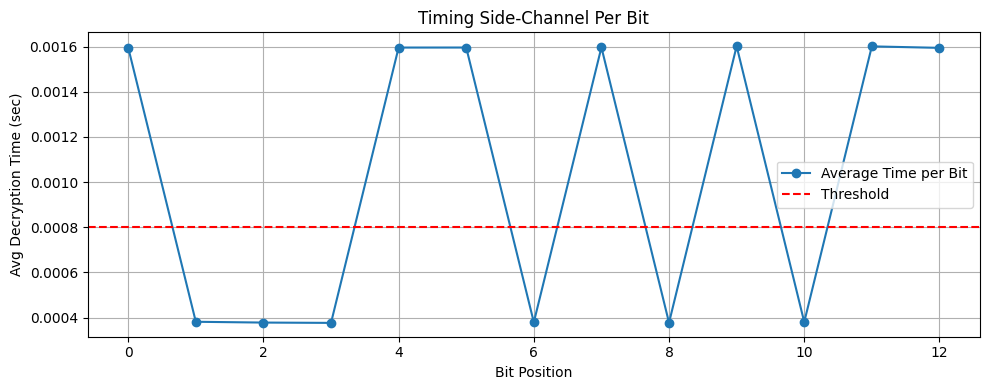

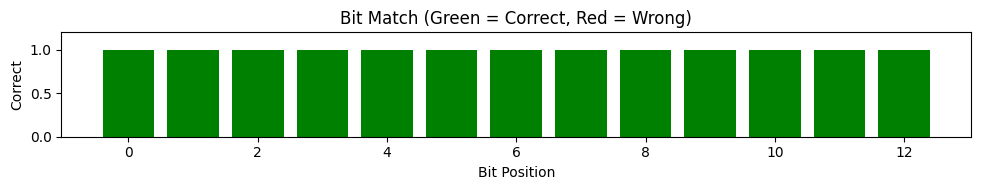

In [ ]:
import time
import random
import matplotlib.pyplot as plt

# Check if a number is prime
def is_prime(n):
    if n < 2:
        return False
    for i in range(2, int(n**0.5)+1):
        if n % i == 0:
            return False
    return True

# Compute GCD
def gcd(a, b):
    while b:
        a, b = b, a % b
    return a

# Compute modular inverse using Extended Euclidean Algorithm
def mod_inverse(e, phi):
    original_phi = phi
    x0, x1 = 0, 1
    while e > 0:
        q, phi, e = phi // e, e, phi % e
        x0, x1 = x1 - q * x0, x0
    return x1 % original_phi

# Generate RSA keys manually
def generate_keys_simple():
    primes = [i for i in range(50, 100) if is_prime(i)]
    p = random.choice(primes)
    q = random.choice(primes)
    while p == q:
        q = random.choice(primes)

    N = p * q
    phi = (p - 1) * (q - 1)
    e = 3
    while gcd(e, phi) != 1:
        e += 2
    d = mod_inverse(e, phi)
    return (e, N), (d, N)

# Encrypt using RSA
def encrypt(m, pub):
    e, N = pub
    return pow(m, e, N)

# Leaky decryption with simulated timing leak
def leaky_decrypt_timed(cipher, priv):
    d, N = priv
    d_bin = bin(d)[2:]
    result = 1
    timings = []

    for bit in d_bin:
        start = time.perf_counter()
        result = (result * result) % N
        if bit == '1':
            time.sleep(0.0015)  # make delay bigger for better signal
            result = (result * cipher) % N
        else:
            time.sleep(0.0003)  # small delay even for 0
        end = time.perf_counter()
        timings.append(end - start)
    return timings

# Timing attack function with stats and plots
def attack_d_with_stats(pub, priv, num_trials=100):
    e, N = pub
    d_bin = bin(priv[0])[2:]
    d_len = len(d_bin)
    timing_matrix = [[] for _ in range(d_len)]

    for _ in range(num_trials):
        m = random.randint(2, N-1)
        c = encrypt(m, pub)
        timings = leaky_decrypt_timed(c, priv)
        for i, t in enumerate(timings):
            timing_matrix[i].append(t)

    guessed_bits = ''
    avg_times = []

    for i, times in enumerate(timing_matrix):
        avg_time = sum(times) / len(times)
        avg_times.append(avg_time)
        guessed_bits += '1' if avg_time > 0.0008 else '0'

    # Print actual vs guessed bits
    print("Actual d:      ", d_bin)
    print("Guessed bits:  ", guessed_bits)

    # Accuracy
    correct = sum(a == b for a, b in zip(d_bin, guessed_bits))
    total = len(d_bin)
    accuracy = correct / total * 100
    print(f"\n Accuracy: {correct}/{total} bits correct ({accuracy:.2f}%)")

    # Plot timing per bit
    plt.figure(figsize=(10, 4))
    plt.plot(avg_times, marker='o', label='Average Time per Bit')
    plt.axhline(0.0008, color='red', linestyle='--', label='Threshold')
    plt.xlabel('Bit Position')
    plt.ylabel('Avg Decryption Time (sec)')
    plt.title('Timing Side-Channel Per Bit')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot bit match
    plt.figure(figsize=(10, 2))
    match = [1 if a == b else 0 for a, b in zip(d_bin, guessed_bits)]
    plt.bar(range(total), match, color=['green' if m == 1 else 'red' for m in match])
    plt.title('Bit Match (Green = Correct, Red = Wrong)')
    plt.xlabel('Bit Position')
    plt.ylabel('Correct')
    plt.ylim(0, 1.2)
    plt.tight_layout()
    plt.show()

# Run everything
public_key, private_key = generate_keys_simple()
attack_d_with_stats(public_key, private_key)